# Random Forest 

In this example, I'm asking **which features are driving the differences between the negcons and treatments for each day: 1, 15 and 30 days of treatment**.

For this:

### 1. Import the functions, define some inputs, and import profiles;
### 2. Run Random Forest in a loop + evaluation
    - Consider that your dataframe has subgroups by which you want to slice the df before calculating the random forest model. 
    - If not your case, go to 3. 
### 3. Run Random Forest + evaluation
### 4. Save shap values and features to df and export

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import easygui as eg
import numpy as np
import sys
import os

sys.path.append(r"C:\Users\Fer\Documents\GitHub") #add here the path in your computer to scripts_notebooks_fossa

from scripts_notebooks_fossa.machine_learning import random_forest_utils

%load_ext autoreload
%autoreload 2

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 1. Inputs

- Define some variables that will be used later in the notebook

In [2]:
myfile = eg.fileopenbox(msg="Choose a file", default=r"F:")
print('Filename', myfile)
df = pd.read_csv(myfile)
df.head()

Filename F:\2022_09_09_LiveCellPainting_fossa_Cimini\workspace\profiles\2022_06_07_DILI\concatenate\2023_2022_DILI_normalized_to_negcon_feature_selected_pycombat.csv


,Metadata_Compound_concentration,Metadata_plate_map_name,Metadata_concentration_uM,Metadata_cell_type,Metadata_compound,Metadata_moa,Metadata_DILI-concern,Metadata_Severity Class,Metadata_control_type,Metadata_Plate,...,Nuclei_Texture_InfoMeas1_CorrPI_5_02_256,Nuclei_Texture_InfoMeas2_CorrGFP_10_01_256,Nuclei_Texture_InfoMeas2_CorrGFP_20_01_256,Nuclei_Texture_InfoMeas2_CorrPI_10_01_256,Nuclei_Texture_InfoMeas2_CorrPI_10_03_256,Nuclei_Texture_InfoMeas2_CorrPI_20_01_256,Nuclei_Texture_InfoMeas2_CorrPI_5_02_256,Nuclei_Texture_InverseDifferenceMoment_CorrPI_20_01_256,Nuclei_Texture_SumEntropy_CorrPI_20_01_256,Nuclei_Texture_Variance_CorrGFP_10_00_256
0,Aspirin_1,platemap_dili,1,Huh7,Aspirin,COX inhibitor,Less-DILI-Concern,0,trt,220607_092050_Plate_1,...,-2.951004,8.972212,9.467828,3.344159,4.973588,4.241367,3.079317,-6.922929,5.085131,20.476580
1,Aspirin_10,platemap_dili,10,Huh7,Aspirin,COX inhibitor,Less-DILI-Concern,0,trt,220607_092050_Plate_1,...,-3.494941,10.111767,10.837145,4.132679,6.764881,5.263887,3.938098,-7.676556,7.503385,25.638036
2,Amiodarone_1,platemap_dili,1,Huh7,Amiodarone,sodium/potassium-ATPase inhibitor,Most-DILI-Concern,8,trt,220607_092050_Plate_1,...,-1.841811,7.829725,8.549107,2.769153,4.238343,3.336620,2.770880,-6.197211,5.967763,18.977983
3,Amiodarone_10,platemap_dili,10,Huh7,Amiodarone,sodium/potassium-ATPase inhibitor,Most-DILI-Concern,8,trt,220607_092050_Plate_1,...,-5.101806,8.749530,9.508322,5.012710,7.773764,6.028070,5.164210,-7.555855,9.888656,25.732000
4,Cyclophosphamide_1,platemap_dili,1,Huh7,Cyclophosphamide,DNA alkylation,\tLess-DILI-Concern,5,trt,220607_092050_Plate_1,...,-1.437264,4.918856,5.257418,2.355868,4.110124,3.459964,2.220202,-5.400153,4.833927,9.023156


In [3]:
#Select which Metadata cols to join and paste into cols_to_join
#new_col is the col name we are using later
cols_to_join = ["Metadata_compound", "Metadata_concentration_uM"]

df, new_col = random_forest_utils.col_generator(df, cols_to_join = cols_to_join)

concentration_uM
Names of the compounds + concentration:  ['Aspirin 1' 'Aspirin 10' 'Amiodarone 1' 'Amiodarone 10'
 'Cyclophosphamide 1' 'Cyclophosphamide 10' 'Etoposide 1' 'Etoposide 10'
 'Non-treated 0' 'Lovastatin 1' 'Lovastatin 10' 'Orphenadrine 1'
 'Orphenadrine 10' 'Lactose 1' 'Lactose 10']


In [ ]:
n_estimators_input=100
max_depth_input=5
number_iterations_input=100

## 2. Filter samples if needed

In [7]:
list_filter_OUT=['Lactose 1','Lactose 10', 'Orphenadrine 1', 'Non-treated 0']
df_filtered = df.query(f'{new_col} not in {list_filter_OUT}').reset_index(drop=True)

## 3. Run Random Forest for 'x' iterations

### All compounds against each other

In [11]:
X, all_feature_importances, aggregate_feature_importances, model = random_forest_utils.random_forest_iterations(df_filtered, 
                                                                    target = 'Metadata_compound', 
                                                                    n_estimators=n_estimators_input, 
                                                                    max_depth=max_depth_input, 
                                                                    number_iterations=number_iterations_input
                                                                    # slice = True, column_slice = "Metadata_Time", slice_to_value = 1
                                                                    # ccp = 0.08
                                                                    )


Mean Training Accuracy: 0.7571428571428569
Mean Testing Accuracy: 0.6170212765957447


In [12]:
feat_importance_sd = np.std(all_feature_importances, axis=0)

In [13]:
feature_ranking = np.argsort(aggregate_feature_importances)[::-1]

In [14]:
features=[]
importance=[]
importance_sd=[]
for i, feature_index in enumerate(feature_ranking):
        if i < 30:
                # print(f"{X.columns[feature_index]}: {aggregate_feature_importances[feature_index]}")
                features.append(X.columns[feature_index])
                importance.append(aggregate_feature_importances[feature_index])
                importance_sd.append(feat_importance_sd[feature_index])

In [15]:
df_results = pd.DataFrame(list(zip(features, importance, importance_sd)), columns=['features', 'importance', 'importance_sd'])

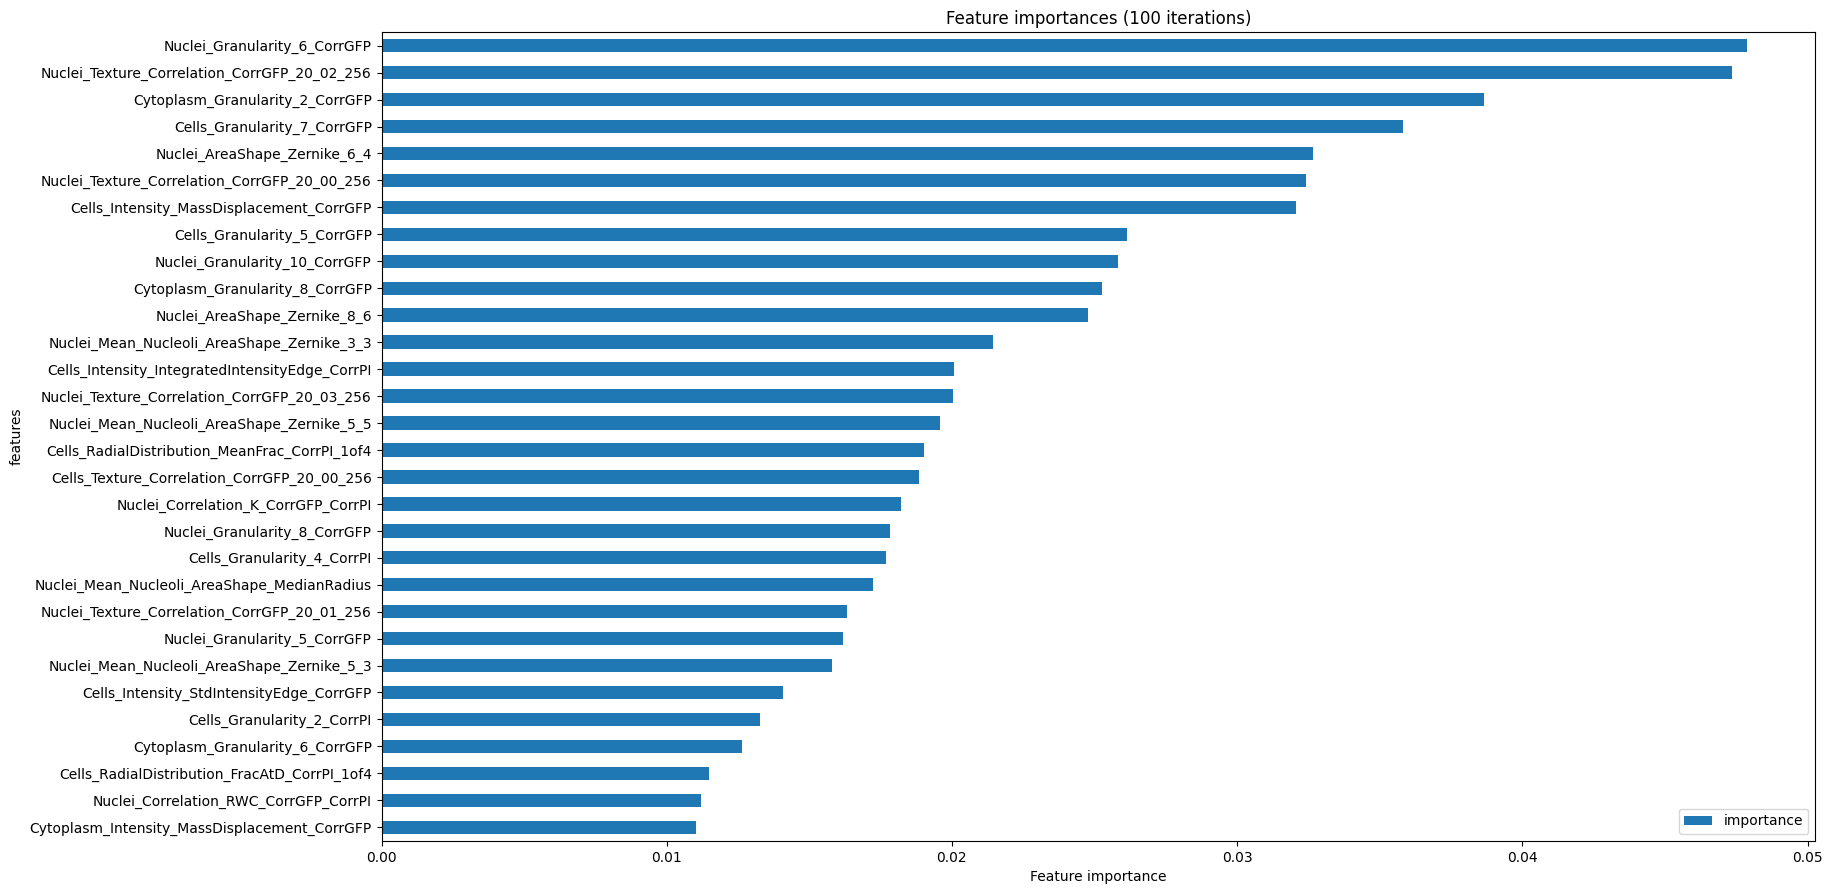

In [16]:
fig, ax = plt.subplots()

df_results.sort_values(by=['importance'],ascending=True).plot.barh(x='features', y='importance', yerr='importance_sd', ax=ax,align="center")
ax.set_title("Feature importances (100 iterations)")
ax.set_xlabel("Feature importance")
fig.set_size_inches(18.5, 10.5)

plt.show()

## Compounds against the negcon

#### First, filter the Orphenadrine 1 because the mAP was below the threshold

In [17]:
list_filter=['Orphenadrine 1']
df_filtered = df.query(f'{new_col} not in {list_filter}').reset_index(drop=True)

['Aspirin', 'Lactose', 'Non-treated']

Mean Training Accuracy: 0.9558823529411762
Mean Testing Accuracy: 0.6521739130434784


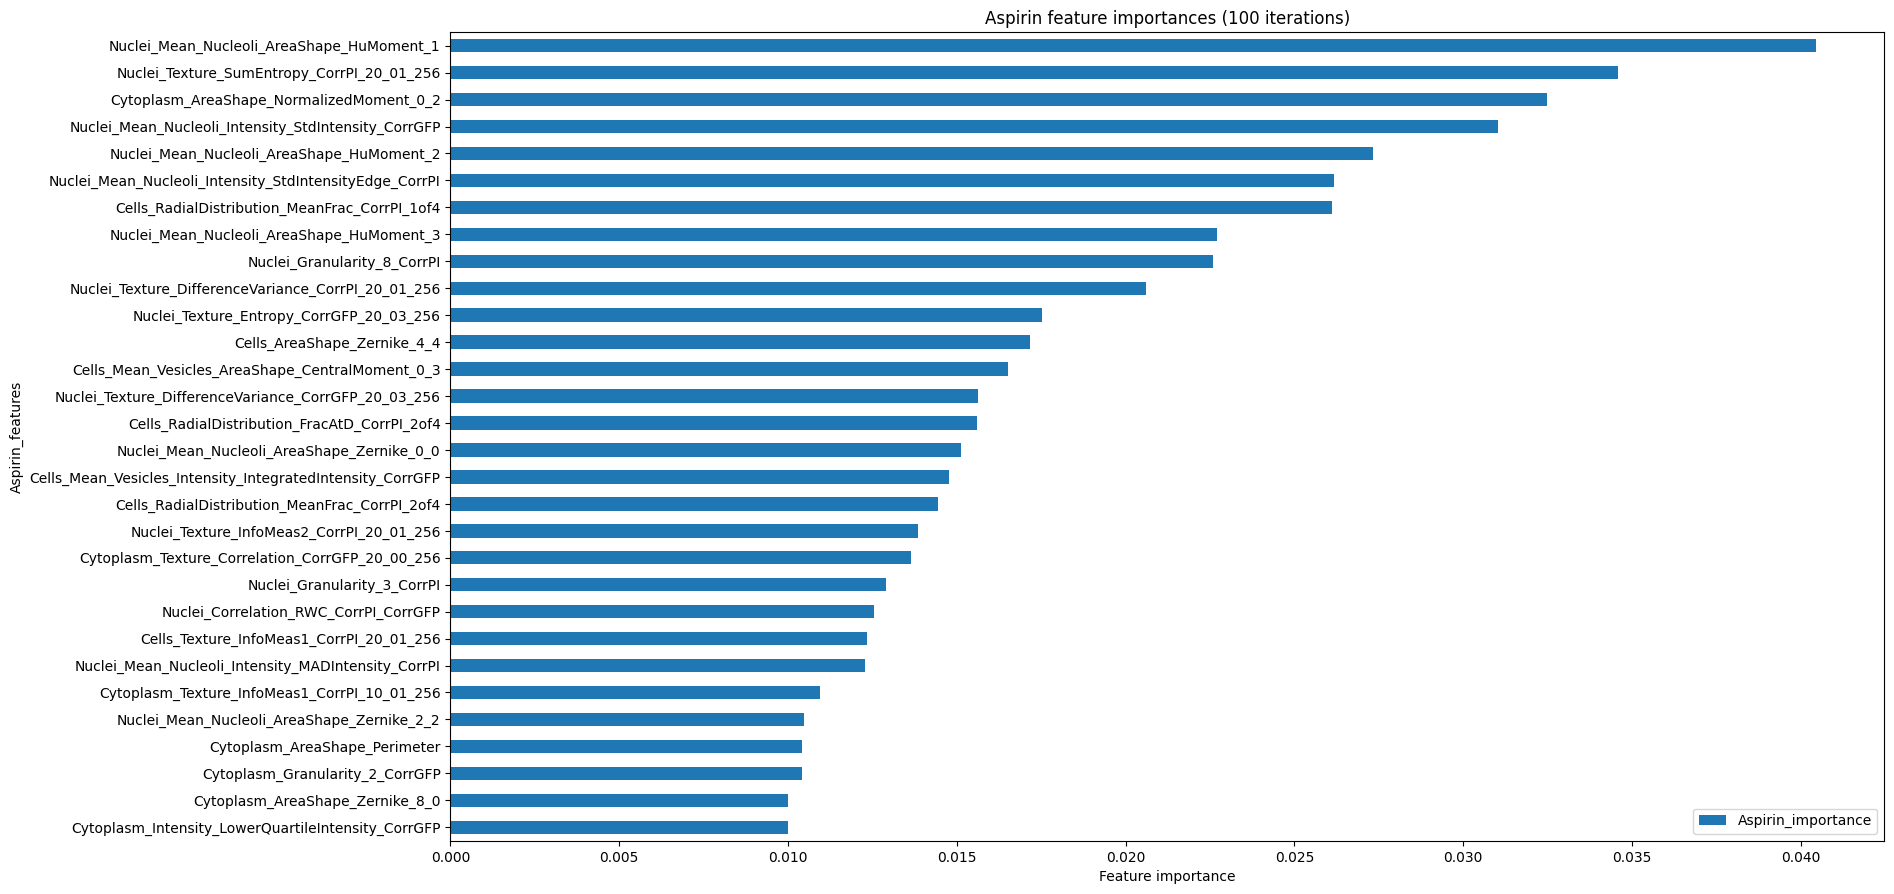

['Amiodarone', 'Lactose', 'Non-treated']

Mean Training Accuracy: 0.9264705882352939
Mean Testing Accuracy: 0.9130434782608695


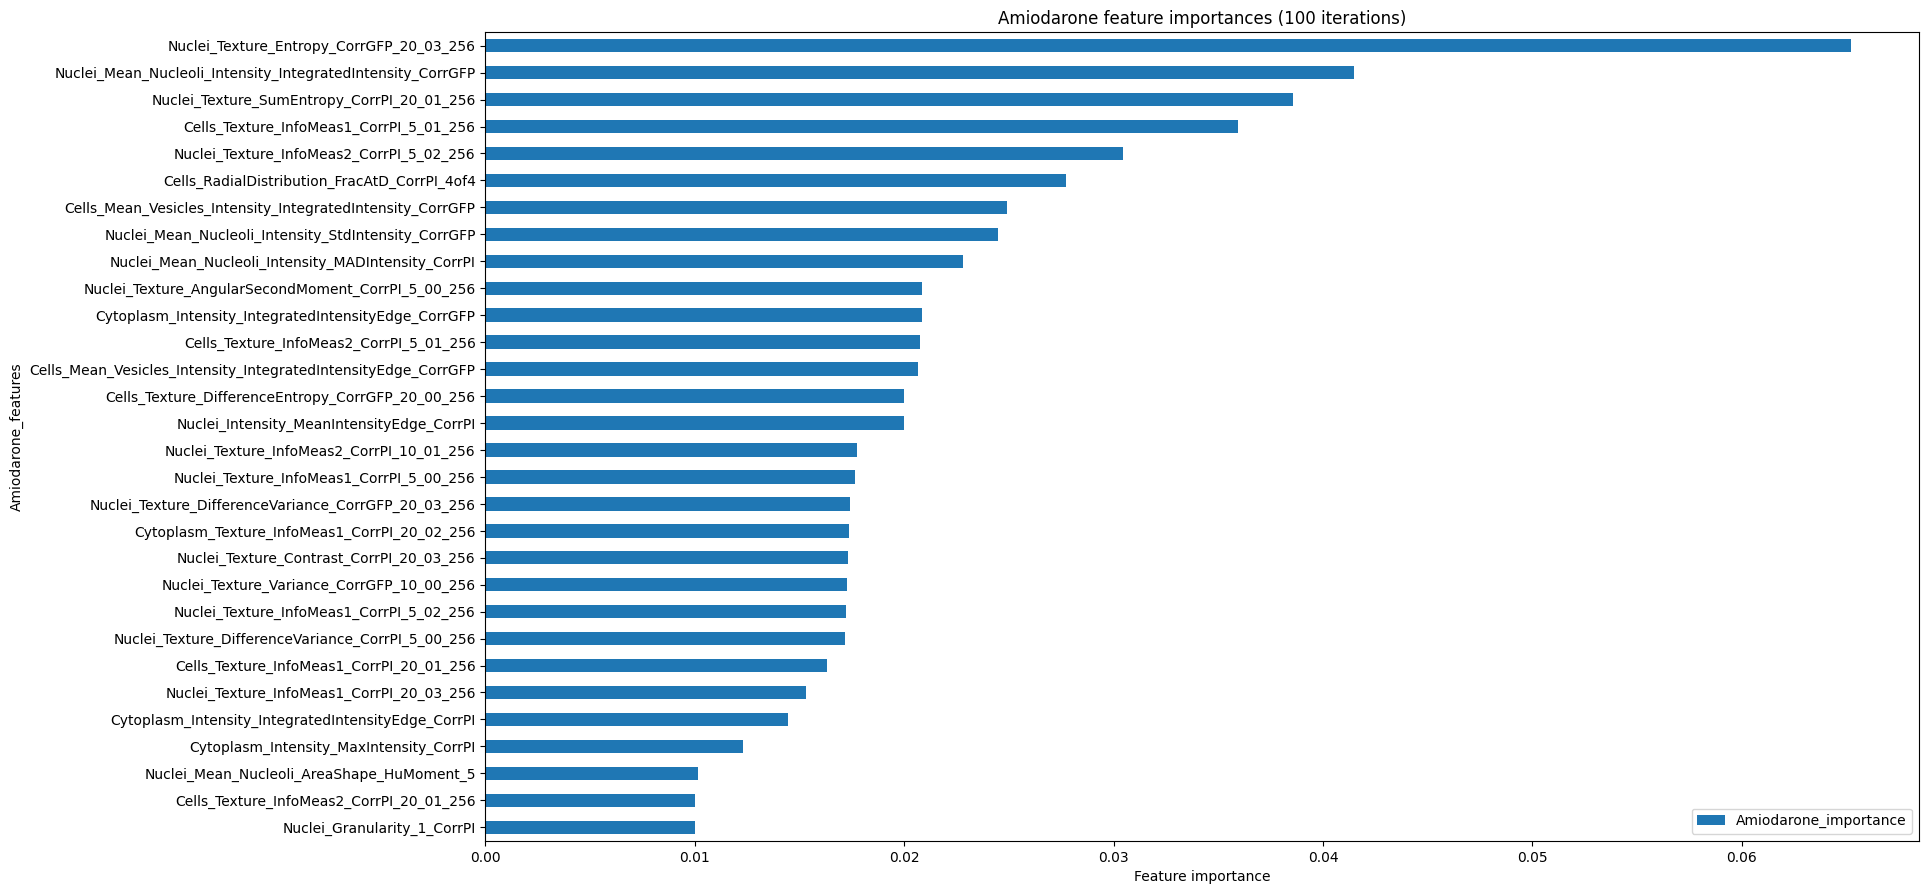

['Cyclophosphamide', 'Lactose', 'Non-treated']

Mean Training Accuracy: 0.9705882352941175
Mean Testing Accuracy: 0.8260869565217388


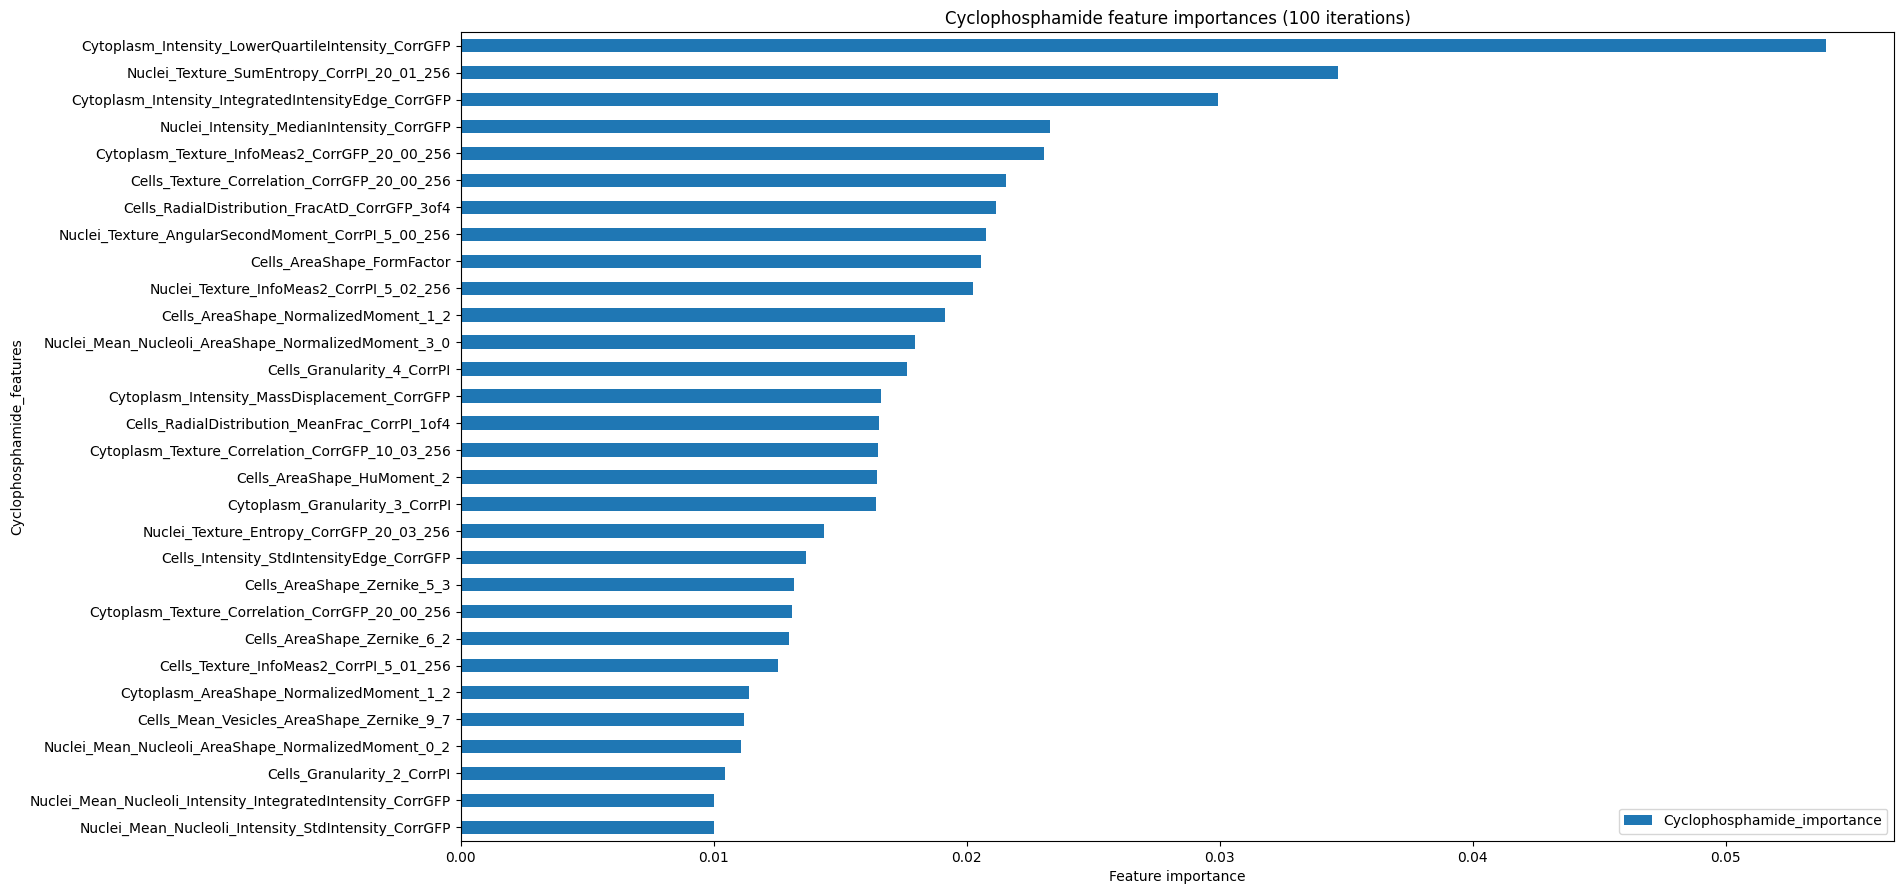

['Etoposide', 'Lactose', 'Non-treated']

Mean Training Accuracy: 1.0
Mean Testing Accuracy: 1.0


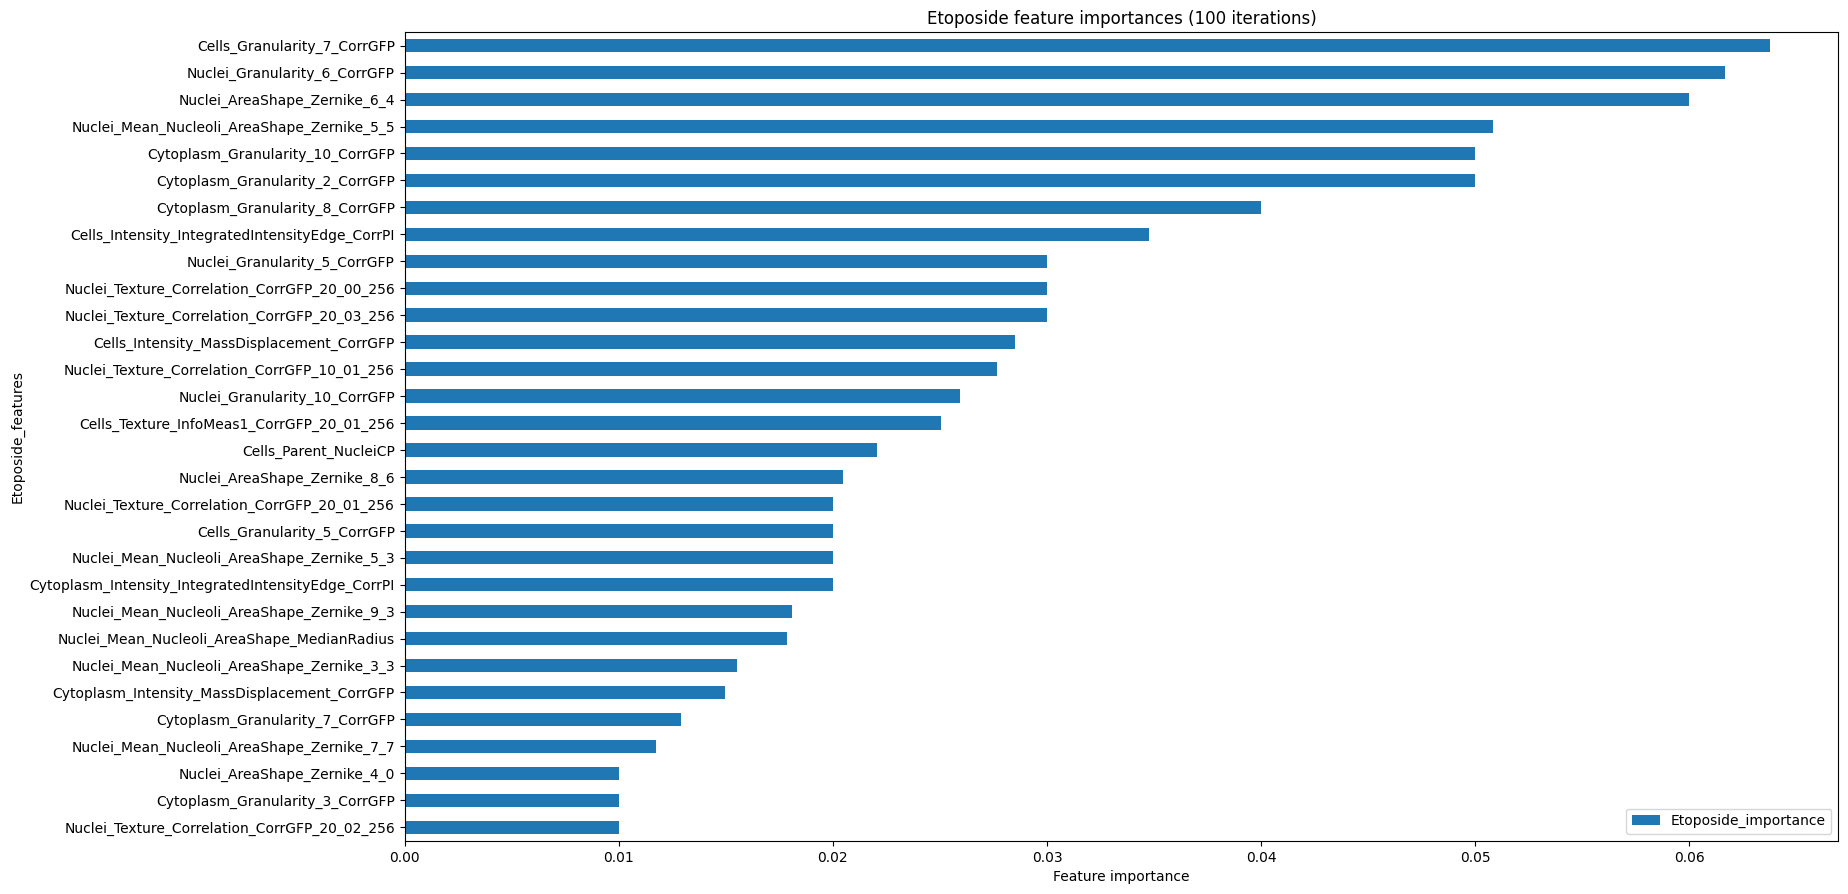

['Lovastatin', 'Lactose', 'Non-treated']

Mean Training Accuracy: 0.9117647058823529
Mean Testing Accuracy: 0.9130434782608695


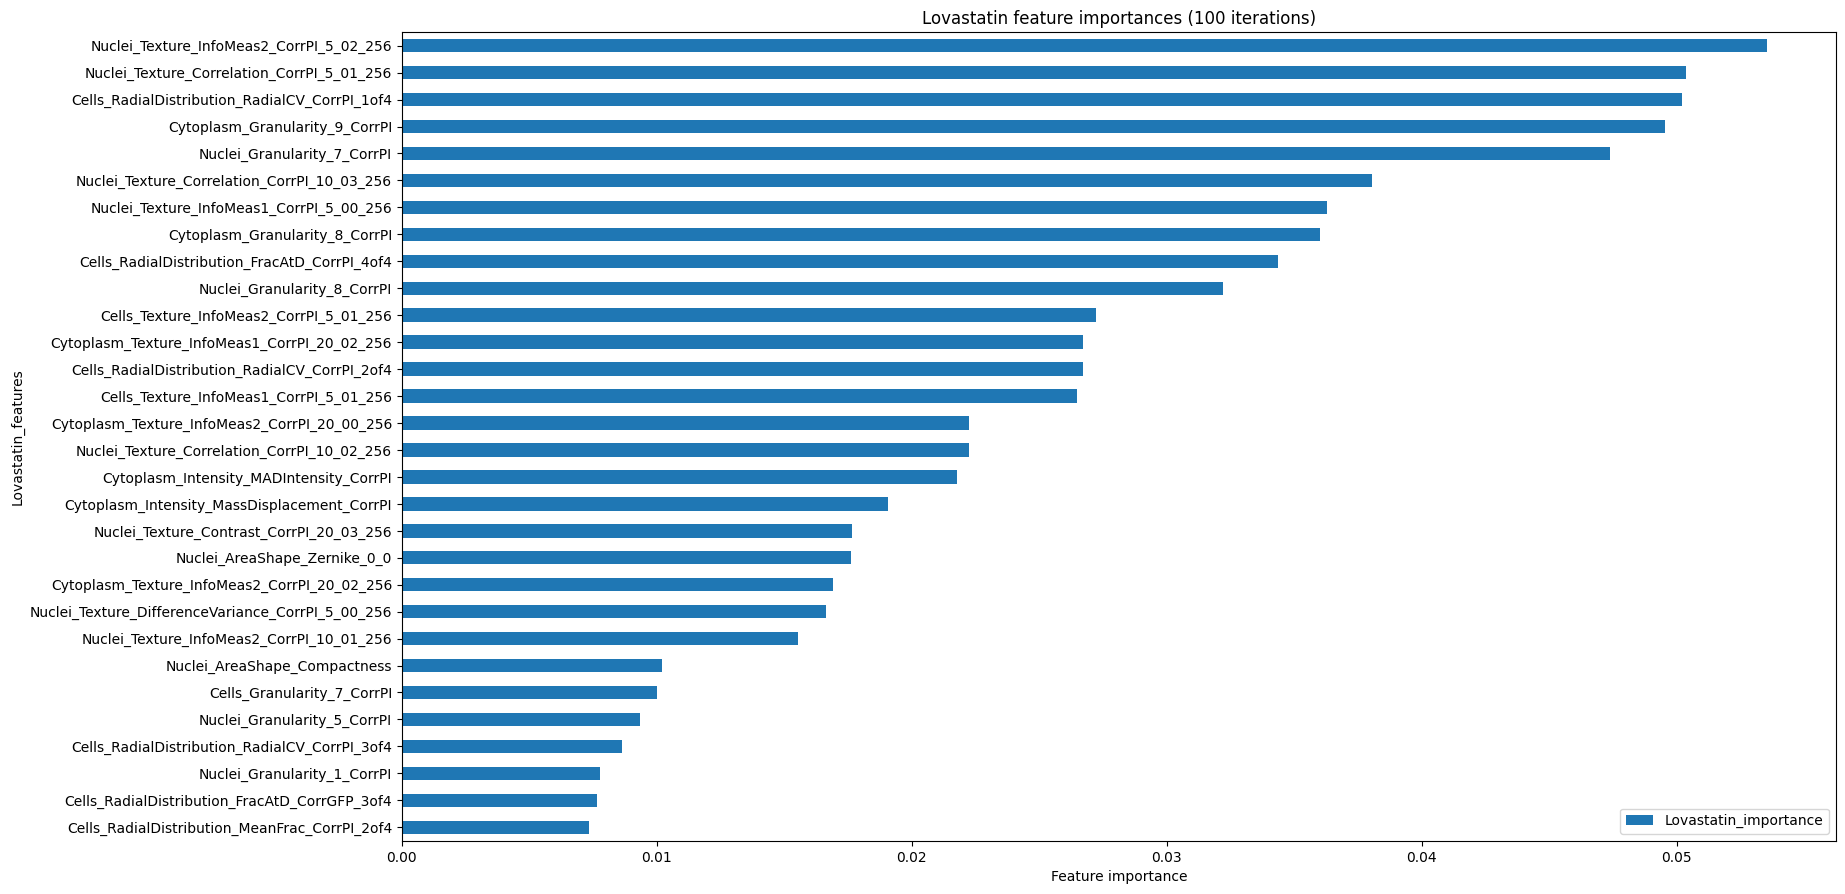

['Orphenadrine', 'Lactose', 'Non-treated']

Mean Training Accuracy: 1.0
Mean Testing Accuracy: 1.0


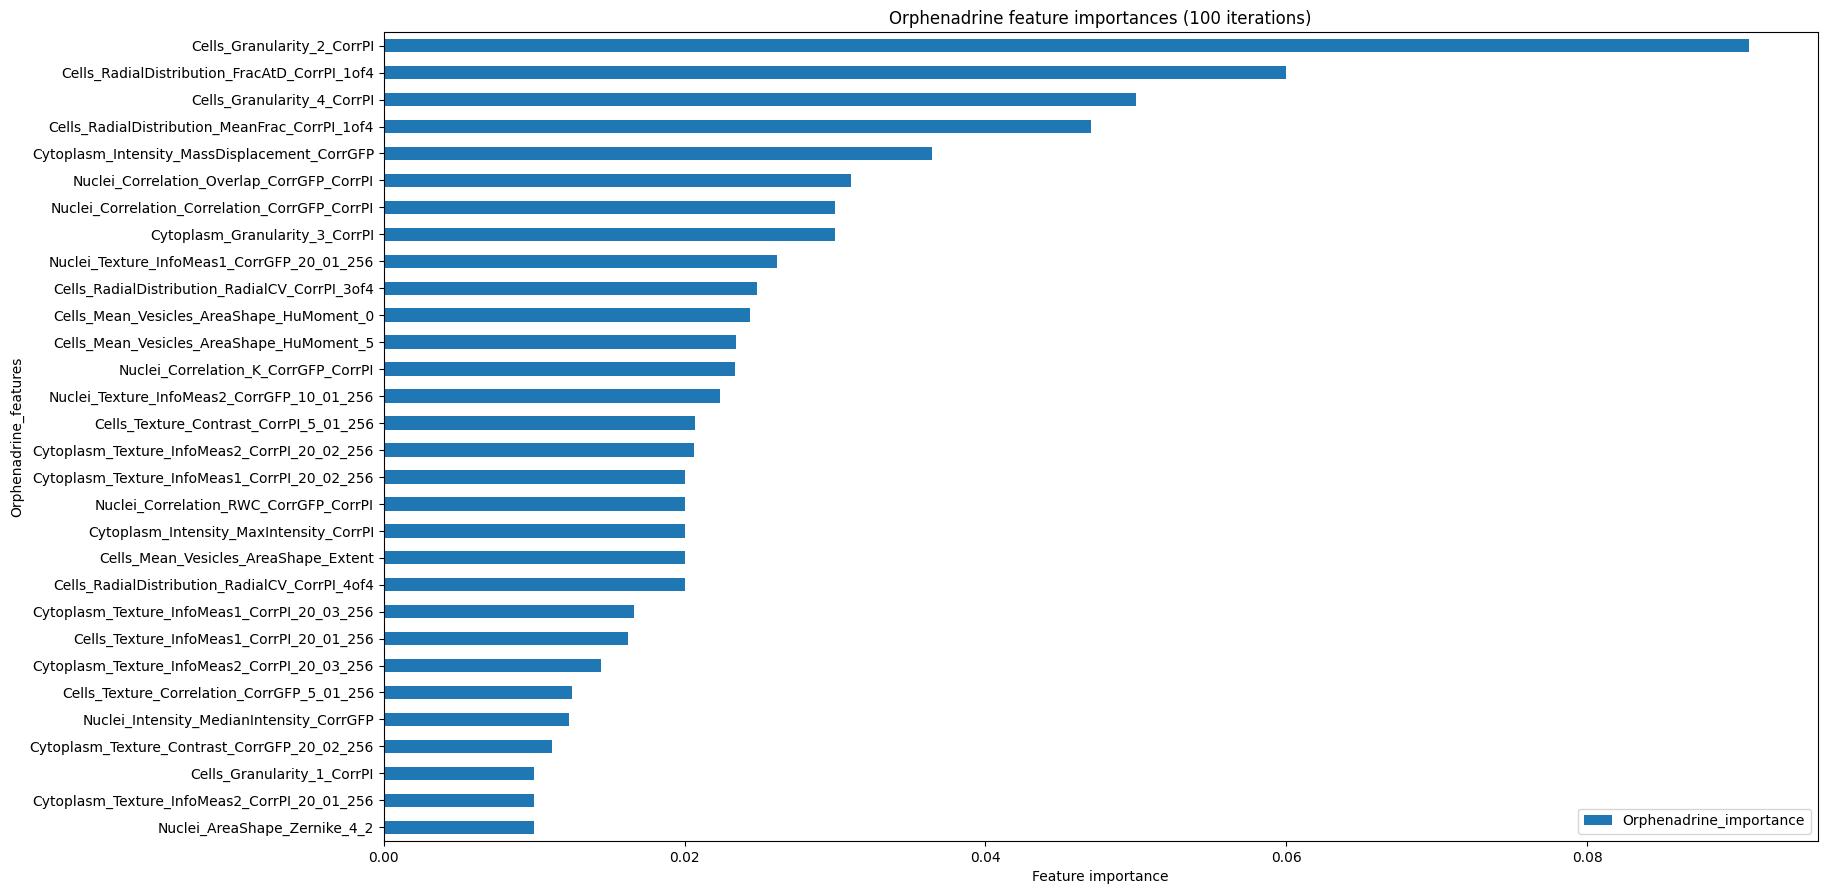

In [41]:
trt=['Aspirin', 'Amiodarone', 'Cyclophosphamide', 'Etoposide', 'Lovastatin', 'Orphenadrine']
slice_to = ['Lactose', 'Non-treated']

df_feats_list=[]

for t in trt:
    slice_to.insert(0, t)
    print(slice_to)
    df_to_random = df_filtered.query(f'Metadata_compound in {slice_to}').reset_index(drop=True)
    
    X, all_feature_importances, aggregate_feature_importances, model = random_forest_utils.random_forest_iterations(df_to_random, 
                                                                    target = 'Metadata_control_type', 
                                                                    n_estimators=100, 
                                                                    max_depth=5, 
                                                                    number_iterations=100
                                                                    )

    df_temp = random_forest_utils.most_important_with_sd(X, all_feature_importances, aggregate_feature_importances, number_of_features_select=30, compound=t)

    df_feats_list.append(df_temp)

    slice_to = ['Lactose', 'Non-treated']

In [43]:
df_feats = pd.concat(df_feats_list, axis='columns')

In [44]:
df_feats

,Aspirin_features,Aspirin_importance,Aspirin_importance_sd,Amiodarone_features,Amiodarone_importance,Amiodarone_importance_sd,Cyclophosphamide_features,Cyclophosphamide_importance,Cyclophosphamide_importance_sd,Etoposide_features,Etoposide_importance,Etoposide_importance_sd,Lovastatin_features,Lovastatin_importance,Lovastatin_importance_sd,Orphenadrine_features,Orphenadrine_importance,Orphenadrine_importance_sd
0,Nuclei_Mean_Nucleoli_AreaShape_HuMoment_1,0.040445,4.857226e-17,Nuclei_Texture_Entropy_CorrGFP_20_03_256,0.065215,2.775558e-17,Cytoplasm_Intensity_LowerQuartileIntensity_Cor...,0.053977,8.326673e-17,Cells_Granularity_7_CorrGFP,0.063778,1.110223e-16,Nuclei_Texture_InfoMeas2_CorrPI_5_02_256,0.053564,1.318390e-16,Cells_Granularity_2_CorrPI,0.090781,9.714451e-17
1,Nuclei_Texture_SumEntropy_CorrPI_20_01_256,0.034590,2.775558e-17,Nuclei_Mean_Nucleoli_Intensity_IntegratedInten...,0.041501,6.938894e-17,Nuclei_Texture_SumEntropy_CorrPI_20_01_256,0.034685,6.938894e-18,Nuclei_Granularity_6_CorrGFP,0.061675,8.326673e-17,Nuclei_Texture_Correlation_CorrPI_5_01_256,0.050356,6.938894e-18,Cells_RadialDistribution_FracAtD_CorrPI_1of4,0.060000,9.714451e-17
2,Cytoplasm_AreaShape_NormalizedMoment_0_2,0.032466,1.387779e-17,Nuclei_Texture_SumEntropy_CorrPI_20_01_256,0.038564,2.775558e-17,Cytoplasm_Intensity_IntegratedIntensityEdge_Co...,0.029948,3.122502e-17,Nuclei_AreaShape_Zernike_6_4,0.060000,9.714451e-17,Cells_RadialDistribution_RadialCV_CorrPI_1of4,0.050222,4.163336e-17,Cells_Granularity_4_CorrPI,0.050000,9.714451e-17
3,Nuclei_Mean_Nucleoli_Intensity_StdIntensity_Co...,0.031033,6.938894e-17,Cells_Texture_InfoMeas1_CorrPI_5_01_256,0.035963,1.387779e-17,Nuclei_Intensity_MedianIntensity_CorrGFP,0.023308,4.857226e-17,Nuclei_Mean_Nucleoli_AreaShape_Zernike_5_5,0.050829,5.551115e-17,Cytoplasm_Granularity_9_CorrPI,0.049534,6.938894e-17,Cells_RadialDistribution_MeanFrac_CorrPI_1of4,0.047012,1.387779e-17
4,Nuclei_Mean_Nucleoli_AreaShape_HuMoment_2,0.027327,3.816392e-17,Nuclei_Texture_InfoMeas2_CorrPI_5_02_256,0.030444,3.122502e-17,Cytoplasm_Texture_InfoMeas2_CorrGFP_20_00_256,0.023078,2.428613e-17,Cytoplasm_Granularity_10_CorrGFP,0.050000,9.714451e-17,Nuclei_Granularity_7_CorrPI,0.047383,6.938894e-18,Cytoplasm_Intensity_MassDisplacement_CorrGFP,0.036470,6.938894e-17
5,Nuclei_Mean_Nucleoli_Intensity_StdIntensityEdg...,0.026161,4.857226e-17,Cells_RadialDistribution_FracAtD_CorrPI_4of4,0.027717,3.469447e-17,Cells_Texture_Correlation_CorrGFP_20_00_256,0.021555,4.163336e-17,Cytoplasm_Granularity_2_CorrGFP,0.050000,9.714451e-17,Nuclei_Texture_Correlation_CorrPI_10_03_256,0.038071,1.387779e-17,Nuclei_Correlation_Overlap_CorrGFP_CorrPI,0.031079,4.163336e-17
6,Cells_RadialDistribution_MeanFrac_CorrPI_1of4,0.026123,2.081668e-17,Cells_Mean_Vesicles_Intensity_IntegratedIntens...,0.024891,6.245005e-17,Cells_RadialDistribution_FracAtD_CorrGFP_3of4,0.021150,1.734723e-17,Cytoplasm_Granularity_8_CorrGFP,0.040000,2.775558e-17,Nuclei_Texture_InfoMeas1_CorrPI_5_00_256,0.036307,8.326673e-17,Nuclei_Correlation_Correlation_CorrGFP_CorrPI,0.030000,4.857226e-17
7,Nuclei_Mean_Nucleoli_AreaShape_HuMoment_3,0.022704,1.387779e-17,Nuclei_Mean_Nucleoli_Intensity_StdIntensity_Co...,0.024482,6.938894e-18,Nuclei_Texture_AngularSecondMoment_CorrPI_5_00...,0.020772,3.816392e-17,Cells_Intensity_IntegratedIntensityEdge_CorrPI,0.034763,6.938894e-17,Cytoplasm_Granularity_8_CorrPI,0.036003,2.081668e-17,Cytoplasm_Granularity_3_CorrPI,0.030000,4.857226e-17
8,Nuclei_Granularity_8_CorrPI,0.022601,2.775558e-17,Nuclei_Mean_Nucleoli_Intensity_MADIntensity_Co...,0.022809,1.387779e-17,Cells_AreaShape_FormFactor,0.020565,2.428613e-17,Nuclei_Granularity_5_CorrGFP,0.030000,4.857226e-17,Cells_RadialDistribution_FracAtD_CorrPI_4of4,0.034356,6.938894e-17,Nuclei_Texture_InfoMeas1_CorrGFP_20_01_256,0.026159,6.938894e-18
9,Nuclei_Texture_DifferenceVariance_CorrPI_20_01...,0.020602,3.469447e-17,Nuclei_Texture_AngularSecondMoment_CorrPI_5_00...,0.020868,3.816392e-17,Nuclei_Texture_InfoMeas2_CorrPI_5_02_2

## Save shap values and features to df and export

In [45]:
experiment="DILI_compounds_vs_negcon"

In [46]:
output = fr"C:\Users\Fer\Documents\GitHub\2022_09_09_LiveCellPainting_fossa_Cimini\analysis\2022_06_07_DILI\2023_new_batch\random_forest"
filename = f"{experiment}.csv"
out = os.path.join(output, filename)
df_feats.to_csv(out, index=False)